# Sales forecast
In this project we try to forecast sales of a national retailer with multiple locations across the country of Ecuador. Ecuador’s economy is dependent on oil. We expect that the price of oil will impact the spending of consumers in Ecuador. We also expect holidays and events in the country to affect the spending.

The data we have is from January 2013 to august of 2017. We have a table for the sales data of all the locations. The price of oil. A table that contains the holidays and events, and a table for store information.

In this project We clean and prepare the data for machine learning, and we use supervised machine learning to forecast the sales.


## Looking at the data
First, we Import the libraries we’ll use for preparing the data. We also look at characteristics of the data.

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
training = pd.read_csv('train.csv', parse_dates=['date'])
stores = pd.read_csv('stores.csv')
oil = pd.read_csv('oil.csv', parse_dates=['date'])
holidays = pd.read_csv('holidays_events.csv', parse_dates=['date'])

In [3]:
training.shape

(3000888, 6)

In [4]:
training.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [5]:
training.describe()

,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


In [6]:
training.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [7]:
oil.head(10)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21
6,2013-01-09,93.08
7,2013-01-10,93.81
8,2013-01-11,93.60
9,2013-01-14,94.27


In [8]:
oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

In [9]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [10]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


## Data cleaning

### Holidays
In holidays table we have holidays, transferred holidays, and events. We need to remove the transferred holidays and standardize the names for all the holidays. We also need to assign local and regional holidays to stores in their locale or region. The same needs to be done for events. After cleaning the holidays table we merge it with the sales table
.

In [11]:
tr1 = holidays[(holidays.type == 'Holiday') & (holidays.transferred == True)].drop('transferred', axis=1).reset_index(drop=True)
tr2 = holidays[(holidays.type == 'Transfer')].drop('transferred', axis=1).reset_index(drop=True)
tr = pd.concat([tr1,tr2], axis = 1)
tr = tr.iloc[:, [5,1,2,3,4]]
holidays = holidays[(holidays.type != 'Transfer') & (holidays.transferred == False)].drop('transferred', axis=1)
holidays = holidays.append(tr).reset_index(drop=True)

In [12]:
holidays['description'] = holidays['description'].str.replace('-','').str.replace('+','').str.replace('\d+','')
holidays['type'] = np.where(holidays['type'] == 'Additional', 'Holiday', holidays['type'])
holidays["description"] = holidays["description"].str.replace("Puente ", "")
holidays['type'] = np.where(holidays['type'] == 'Bridge', 'Holiday', holidays['type'])

In [13]:
holidays = holidays[holidays.type != 'Work Day']
events = holidays[holidays.type == 'Event'].drop(['locale','locale_name','type'], axis=1).rename({'description':'events'}, axis=1)
holidays = holidays[holidays.type != 'Event'].drop('type',axis=1)

In [14]:
regional = holidays[holidays.locale == 'Regional'].rename({'description':'holiday_regional','locale_name':'state'}, axis=1).drop('locale',axis=1).drop_duplicates()
national = holidays[holidays.locale == 'National'].rename({'description':'holiday_national'}, axis=1).drop(['locale','locale_name'],axis=1).drop_duplicates()
local = holidays[holidays.locale == 'Local'].rename({'description':'holiday_local','locale_name':'city'}, axis=1).drop('locale',axis=1).drop_duplicates()

In [15]:
events['events'] =np.where(events['events'].str.contains('futbol'), 'Futbol', events['events'])

In [16]:
df = pd.merge(training,stores)

In [17]:
df = pd.merge(df, regional, how='left', on=['state','date'])
df = pd.merge(df, national, how='left')
df = pd.merge(df, local, how='left', on=['city','date'])
df = pd.merge(df,events,how='left')

In [18]:
df.isna().sum()

id                        0
date                      0
store_nbr                 0
family                    0
sales                     0
onpromotion               0
city                      0
state                     0
type                      0
cluster                   0
holiday_regional    3001647
holiday_national    2863674
holiday_local       2990790
events              2902878
dtype: int64

In [19]:
df['holiday_regional']=df['holiday_regional'].fillna(0)
df['holiday_national']=df['holiday_national'].fillna(0)
df['holiday_local']=df['holiday_local'].fillna(0)
df['events']=df['events'].fillna(0)

### Time features
We add time features to the sales data to improve the accuracy of the model. We also add the weekend days and wage days.

In [20]:
df['month'] = df.date.dt.month
df['day_of_month'] = df.date.dt.day
df['day_of_year'] = df.date.dt.dayofyear
df['day_of_week'] = (df.date.dt.dayofweek + 1)
df['year'] = df.date.dt.year
df["quarter"] = df.date.dt.quarter
df["is_wknd"] = pd.Series(np.where((df['day_of_week'] == 6) | (df["day_of_week"] == 7), 1, 0))
df["wageday"] = pd.Series(np.where((df['day_of_month'] == 1) | (df["day_of_month"] == 15), 1, 0))

In [21]:
day = pd.DataFrame({'date':pd.date_range(start="2013-01-01",end="2017-08-31")})
day['d'] = range(1,len(day)+1)
df = pd.merge(df,day,how='left',on='date')
df

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,events,month,day_of_month,day_of_year,day_of_week,year,quarter,is_wknd,wageday,d
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,...,0,1,1,1,2,2013,1,0,1,1
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,...,0,1,1,1,2,2013,1,0,1,1
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,...,0,1,1,1,2,2013,1,0,1,1
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,...,0,1,1,1,2,2013,1,0,1,1
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,...,0,1,1,1,2,2013,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3002665,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,...,0,8,15,227,2,2017,3,0,1,1688
3002666,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,...,0,8,15,227,2,2017,3,0,1,1688
3002667,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,...,0,8,15,227,2,2017,3,0,1,1688
3002668,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,...,0,8,15,227,2,2017,3,0,1,1688


### Oil prices
The oil price data doesn’t include weekends. We add the weekend days and fill the price with the last day before the weekend.

In [22]:
oildate = pd.DataFrame({'date':pd.date_range(start="2013-01-01",end="2017-08-31")})
oil = pd.merge(oildate,oil,how='left')
oil['dcoilwtico'] = oil['dcoilwtico'].ffill(axis = 0)
df = pd.merge(df, oil, how='left', on='date')
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,month,day_of_month,day_of_year,day_of_week,year,quarter,is_wknd,wageday,d,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,1,1,1,2,2013,1,0,1,1,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,1,1,1,2,2013,1,0,1,1,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,1,1,1,2,2013,1,0,1,1,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,1,1,1,2,2013,1,0,1,1,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,1,1,1,2,2013,1,0,1,1,NaN


In [23]:
df = df[df.date > '2013-01-01']

In [24]:
df.isna().sum()

id                  0
date                0
store_nbr           0
family              0
sales               0
onpromotion         0
city                0
state               0
type                0
cluster             0
holiday_regional    0
holiday_national    0
holiday_local       0
events              0
month               0
day_of_month        0
day_of_year         0
day_of_week         0
year                0
quarter             0
is_wknd             0
wageday             0
d                   0
dcoilwtico          0
dtype: int64

In [25]:
df = df.drop('date', axis=1)

## Preparing the data for ML
We define two functions one to downcast numerical variables and change objects to category. The other to change categories to numerical variables.

In [26]:
def get_cat_codes(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,type in enumerate(types):
        if type.name == 'category':
            df[cols[i]] = df[cols[i]].cat.codes

In [27]:
def typecast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == object:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

In [28]:
typecast(df)

,id,store_nbr,family,sales,onpromotion,city,state,type,cluster,holiday_regional,...,month,day_of_month,day_of_year,day_of_week,year,quarter,is_wknd,wageday,d,dcoilwtico
33,1782,1,AUTOMOTIVE,2.000000,0,Quito,Pichincha,D,13,0,...,1,2,2,3,2013,1,0,0,2,93.1250
34,1783,1,BABY CARE,0.000000,0,Quito,Pichincha,D,13,0,...,1,2,2,3,2013,1,0,0,2,93.1250
35,1784,1,BEAUTY,2.000000,0,Quito,Pichincha,D,13,0,...,1,2,2,3,2013,1,0,0,2,93.1250
36,1785,1,BEVERAGES,1091.000000,0,Quito,Pichincha,D,13,0,...,1,2,2,3,2013,1,0,0,2,93.1250
37,1786,1,BOOKS,0.000000,0,Quito,Pichincha,D,13,0,...,1,2,2,3,2013,1,0,0,2,93.1250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3002665,3000883,9,POULTRY,438.132996,0,Quito,Pichincha,B,6,0,...,8,15,227,2,2017,3,0,1,1688,47.5625
3002666,3000884,9,PREPARED FOODS,154.552994,1,Quito,Pichincha,B,6,0,...,8,15,227,2,2017,3,0,1,1688,47.5625
3002667,3000885,9,PRODUCE,2419.729004,148,Quito,Pichincha,B,6,0,...,8,15,227,2,2017,3,0,1,1688,47.5625
3002668,3000886,9,SCHOOL AND OFFICE SUPPLIES,121.000000,8,Quito,Pichincha,B,6,0,...,8,15,227,2,2017,3,0,1,1688,47.5625


In [29]:
get_cat_codes(df)
df

,id,store_nbr,family,sales,onpromotion,city,state,type,cluster,holiday_regional,...,month,day_of_month,day_of_year,day_of_week,year,quarter,is_wknd,wageday,d,dcoilwtico
33,1782,1,0,2.000000,0,18,12,3,13,0,...,1,2,2,3,2013,1,0,0,2,93.1250
34,1783,1,1,0.000000,0,18,12,3,13,0,...,1,2,2,3,2013,1,0,0,2,93.1250
35,1784,1,2,2.000000,0,18,12,3,13,0,...,1,2,2,3,2013,1,0,0,2,93.1250
36,1785,1,3,1091.000000,0,18,12,3,13,0,...,1,2,2,3,2013,1,0,0,2,93.1250
37,1786,1,4,0.000000,0,18,12,3,13,0,...,1,2,2,3,2013,1,0,0,2,93.1250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3002665,3000883,9,28,438.132996,0,18,12,1,6,0,...,8,15,227,2,2017,3,0,1,1688,47.5625
3002666,3000884,9,29,154.552994,1,18,12,1,6,0,...,8,15,227,2,2017,3,0,1,1688,47.5625
3002667,3000885,9,30,2419.729004,148,18,12,1,6,0,...,8,15,227,2,2017,3,0,1,1688,47.5625
3002668,3000886,9,31,121.000000,8,18,12,1,6,0,...,8,15,227,2,2017,3,0,1,1688,47.5625


## Machine learning
We import the libraries we’ll use for forecasting. Also, we split the data to training set, validation set, and testing set.

In [30]:
import seaborn as sns
import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [31]:
x_train, y_train = df[df.d > 1601].drop('sales',axis=1), df[df.d > 1601].sales
x_val, y_val = df[(df.d > 1600) & (df.d <= 1640)].drop('sales',axis=1), df[(df.d > 1600) & (df.d <= 1640)].sales
x_test, y_test = df[df.d > 1640].drop('sales',axis=1), df[df.d > 1640].sales

## Model selection
We use the training and validation set to choose the best model.

In [32]:
regressor = [LinearRegression(), DecisionTreeRegressor(random_state=0), KNeighborsRegressor()]

In [33]:
results = []
for reg in regressor:
    model = reg
    model.fit(x_train, y_train)
    yhat = model.predict(x_val)
    r_2 = r2_score(y_val, yhat)
    model_metadata = {'Model': reg, 'r_2 score':r_2}
    results.append(model_metadata)

pd.DataFrame(results)

,Model,r_2 score
0,LinearRegression(),0.340462
1,DecisionTreeRegressor(random_state=0),0.997113
2,KNeighborsRegressor(),0.529744


## Forecast
We use the best model to forecast with unseen data.

In [34]:
train_features, train_targets = df[df.d < 1640].drop('sales',axis=1), df[df.d <1640].sales

In [35]:
model = DecisionTreeRegressor(random_state=0)
model.fit(train_features, train_targets)
yhat = model.predict(x_test)
r2_score(y_test, yhat)

0.8149564124644768

In [36]:
x_test['sales'] = yhat

<AxesSubplot:xlabel='d', ylabel='sales'>

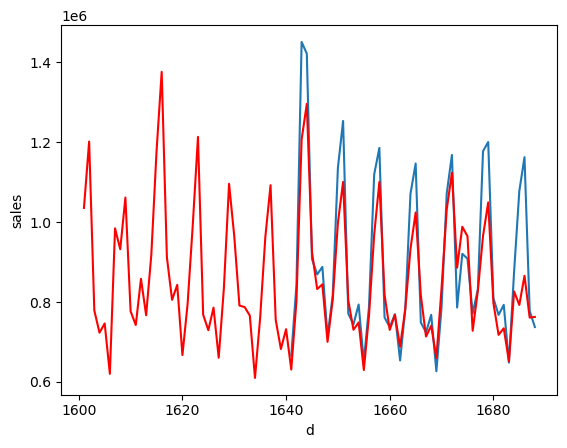

In [37]:
ax = sns.lineplot(x_test.groupby('d').sum(),x='d',y='sales')
sns.lineplot(df[(df.d > 1600) & (df.d < 1689)].groupby('d').sum(),x='d',y='sales',color='r')